# Exploring Events Data from Burning Man Festival

![](images/TitlePage.jpg)

Burning Man is a week-long annual arts and entertainment festival in Northwest Nevada, started in 1989, that attracts almost 70,000 attendees from all over the world. Burning Man has a decentralized non-profit structure. Attendees (aka Burners) self-organize into groups (called camps) that host numerous events. Since 2009, a portion of these events have been publicized ahead of time in an online schedule. This notebook is an exploration of that dataset

In [42]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
import numpy as np;

import fuzzywuzzy
from fuzzywuzzy import process

from functools import reduce
from tqdm import tqdm
from pylab import *;

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import nltk, re, pprint
from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import RegexpTokenizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

from scipy import sparse

%matplotlib inline

The dataset (which was scraped and cleaned in another notebook) consists of over 20,000 events dating back to 2009. Along with the event name, several variables including the event description, the hosting camp, location, type, and date are included.

Here's an example. The Bad Idea Bar. This event occurs almost every day at midnight at a camp called The Academy of Arts and Sciences. It's a "Gathering/Party" type event. And it's description pretty clearly says what's going to happen at the event. But, there's clearly a data quality issue with the event time. Midnight to 11:45 PM doesn't really make sense. We can assume that means it starts at around midnight and continues until whenever, but this can make the data analysis tricky. 

![](images/Example.jpg)

In [3]:
df = pd.read_csv('raw_data/cleaned_up.csv')

df.sample(5)

,Description,Title,Hosted by Camp,Location,Type,Contact Email,URL,Located at Art,Year,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2
19958,Earn your Masters in Social Twerk! Show your t...,Twerkshop,Cosmic Ranch,NaN,Class/Workshop,NaN,NaN,NaN,2017,0,0,0,0,0,8:30 p.m. – 9:30 p.m.,0,0,0
1202,Join Gigsville's most esteemed & talented Camp...,pole dancing workshop,Gigsville,NaN,Gathering/Party,NaN,NaN,NaN,2009,0,0,0,0,10 p.m. – 11 p.m.,0,0,0,0
13028,Potential dates are ask questions by the parti...,DATING GAME,Dr.Baron von Realz esq. Steampunk,NaN,Game,NaN,NaN,NaN,2015,0,0,0,0,5 p.m. – 7 p.m.,0,0,0,0
7221,learn about tantric sexual healing from a pane...,"What is tantric sexual healing, & is it for you?",HeeBeeGeeBee Healers,NaN,Adult-oriented,NaN,NaN,NaN,2013,0,0,0,noon – 12:45 p.m.,0,0,0,0,0
5819,Black Rock Vineyard and Wine Cellar provide wi...,French Quarter Wine Education and Tasting,NaN,French Quarter @ 7:30 & A,Class/Workshop,wineaux@blackrockvinyards.org,http://www.blackrockwinecellar.org/,NaN,2012,0,0,0,1 p.m. – 3 p.m.,0,0,0,0,0


In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 18 columns):
Description       20165 non-null object
Title             20165 non-null object
Hosted by Camp    18258 non-null object
Location          7145 non-null object
Type              20165 non-null object
Contact Email     8749 non-null object
URL               8529 non-null object
Located at Art    444 non-null object
Year              20165 non-null int64
Sunday            20165 non-null object
Monday            20165 non-null object
Tuesday           20165 non-null object
Wednesday         20165 non-null object
Thursday          20165 non-null object
Friday            20165 non-null object
Saturday          20165 non-null object
Sunday2           20165 non-null object
Monday2           20165 non-null object
dtypes: int64(1), object(17)
memory usage: 2.8+ MB


# Missing Values

Looks like very events have labels regarding whether they're near art pieces. 

Approximately 50% are also missing location data, which may make them hard to find! Location could possibly be inferred by the camp name and/or the event description however. 

Many events are also missing a URL or Contact Email, although this is probably not very important for Burning Man. 

Around 10% of events are missing camp information as well, which is quite important, but again, might be inferred from the description.

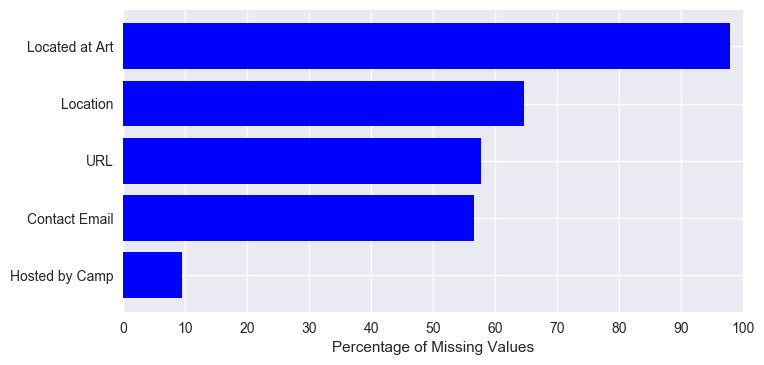

In [182]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9

fig = plt.figure(figsize=(8, 4), dpi=100)
ax = fig.add_subplot(111)

rects = ax.barh(ind, 100*missing_df.missing_count.values/len(df), color='blue')
ax.set_xbound(0, 100)
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Percentage of Missing Values")
ax.xaxis.set_major_locator(MultipleLocator(10))

plt.show()

# Number of Events over the Years

The total number of scheduled events has been steadily rising over the years, which can be  largely attributed to increased promotion and use of the event scheduling system. It's unclear whether the actual number of events has been increasing.

By type, much of this growth belongs to increased numbers of classes/workshops and parties. Other types of events have exhibited either slow or no growth. This means that going forward to future years, we can likely expect even larger fractions of worshop and party type events.

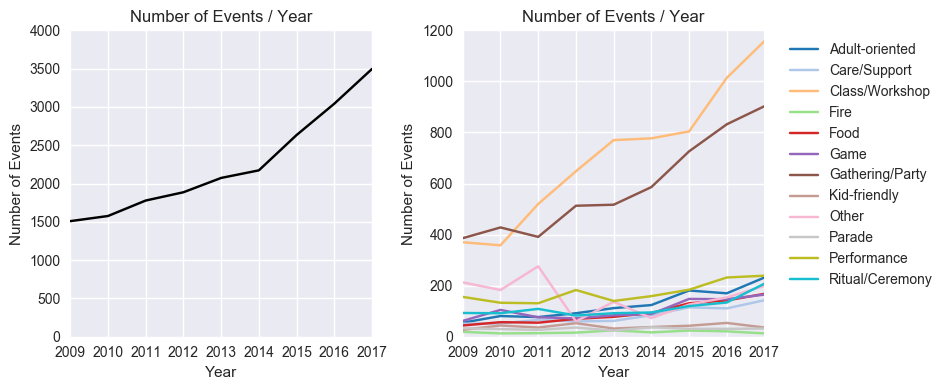

In [135]:
start = 0.0;
stop  = 1.0;
number_of_lines = len(grouped_by_type_year.index.levels[0]) + 1;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100)

axes1 = fig.add_subplot(121)

axes1.plot(df_year_counts.index, df_year_counts.values, color='black', ls='-')

#axes1.grid(False)
#axes1.set_facecolor('white')
axes1.set_xlim(2009, 2017)
axes1.set_ylim(0, 4000)

axes1.set_xlabel('Year')
axes1.set_ylabel('Number of Events')
axes1.set_title('Number of Events / Year')

axes1.xaxis.set_major_locator(MultipleLocator(1))

axes2 = fig.add_subplot(122)

for i, event_type in enumerate(grouped_by_type_year.index.levels[0]):
    axes2.plot(grouped_by_type_year[event_type].sort_index().index.values, 
               grouped_by_type_year[event_type].sort_index().values, 
               color=colors[i], ls='-')

axes2.legend(grouped_by_type_year.index.levels[0], loc='upper right', bbox_to_anchor=(1.6, 1.0))
    
#axes2.grid(False)
#axes2.set_facecolor('white')
axes2.set_xlim(2009, 2017)
axes2.set_ylim(0, 1200)

axes2.set_xlabel('Year')
axes2.set_ylabel('Number of Events')
axes2.set_title('Number of Events / Year')

axes2.xaxis.set_major_locator(MultipleLocator(1))

fig.tight_layout();

# Event Type Distribution

More clearly visualizing the distribution of event types, we can see that gathering/party and class/workshop events are very popular, with relatively few kid-friendly and fire type events. Therefore classifying events into different types will suffer from data imbalance issues. In other words, we don't have equal distributions of all event types.

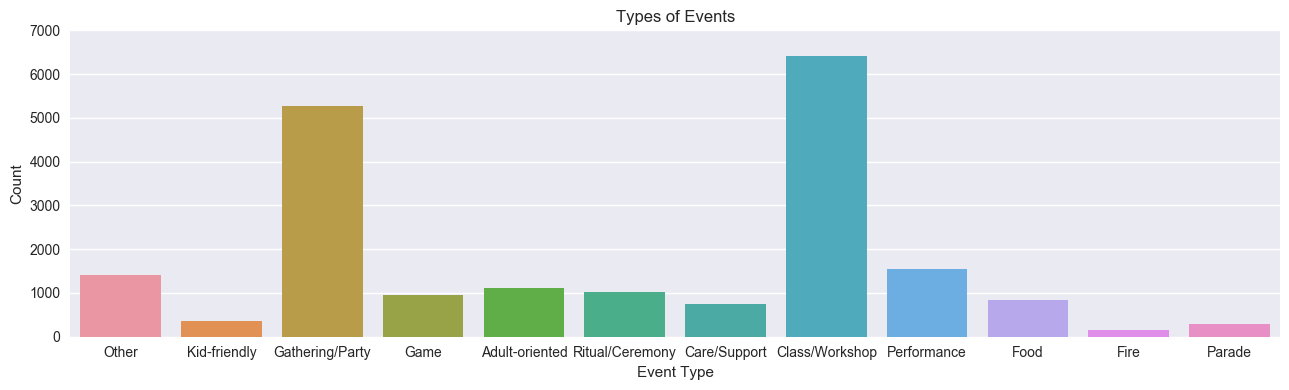

In [553]:
fig = plt.figure(figsize=(13, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.countplot(df.Type, ax=axes1)

axes1.set_ylim(0, 7000);
axes1.set_xlabel('Event Type');
axes1.set_ylabel('Count');
axes1.set_title('Types of Events');

fig.tight_layout()

# Events by Day

Let's take a look at the event distribution by day. The middle of the week (Wednesday) seems to be the busiest. Makes sense. Early in the week people are still arriving and setting things up. Later in the week people get into party mode, and then pack out. 

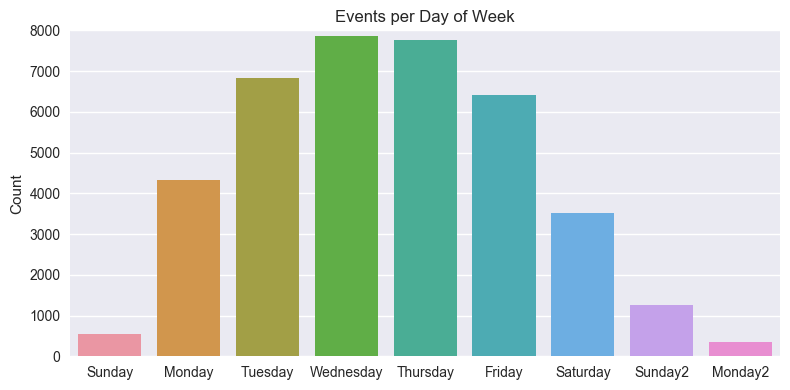

In [215]:
counts = (df[df.columns.values[-9:]] != '0').sum().reset_index().rename(columns={"index": "day", 0:"count"})

fig = plt.figure(figsize=(8, 4), dpi=100)

axes1 = fig.add_subplot(111)

sns.barplot(x='day', y='count', data=counts, ax=axes1)

axes1.set_ylim(0, 8000)
axes1.set_xlabel('')
axes1.set_ylabel('Count')
axes1.set_title('Events per Day of Week')

fig.tight_layout()

For the most part, the event distributions by type are the same. It does seem like performances are slightly skewed towards later in the week.

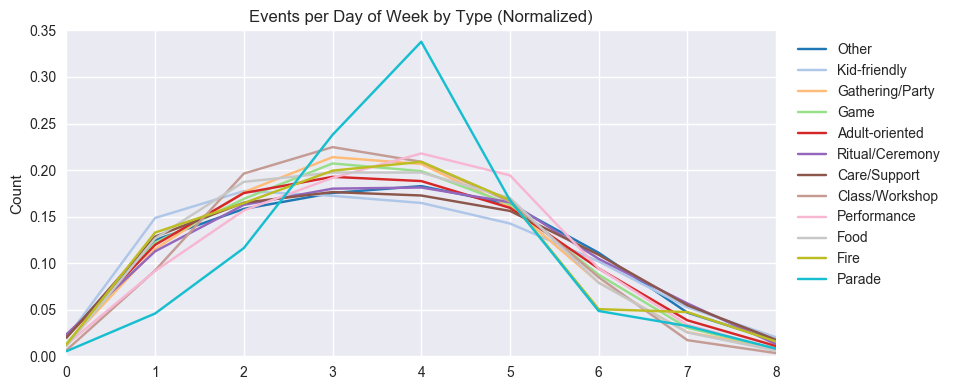

In [586]:
event_types = df['Type'].unique()

start = 0.0;
stop = 1.0;
number_of_lines = len(event_types) + 1;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100)

axes1 = fig.add_subplot(111)

for i, event_type in enumerate(event_types):
    temp_df = (df[df['Type'] == event_type][df.columns.values[-9:]] != '0').sum().reset_index().rename(columns={"index": "day", 0:"count"})
    
    axes1.plot(temp_df.index, temp_df['count']/temp_df['count'].sum(), color=colors[i], ls='-');

axes1.legend(event_types, loc='upper right', bbox_to_anchor=(1.25, 1));
 
axes1.set_xlim(0, 8)
axes1.set_ylim(0, 0.35)
axes1.set_xlabel('')
axes1.set_ylabel('Count')
axes1.set_title('Events per Day of Week by Type (Normalized)')

fig.tight_layout()

Let's next investigate the event distribution by hour. To do so we'll need to construct a function that parses the data and returns a distribution.

In [815]:
def convert_12_to_24(time):
    if 'a.m.' in time:
        time = time.replace(' a.m.', '')
        if ':' not in time:
            time = time + ':00'    
    elif 'p.m.' in time:
        time = time.replace(' p.m.', '')
        if ':' not in time:
            if '12' in time:
                time = time + ':00'
            else:
                time = str(int(time)+12) + ':00'
        elif '12' in time:
            pass
        else:
            time_split = time.split(':')
            time = str(int(time_split[0])+12) + ':' + time_split[1]
    elif 'midnight' in time:
        time = '23:45'
    elif 'noon' in time:
        time = '12:00'
            
    return time

def construct_cumulative_times(df):
    # df = dataframe consisting of a list of times
        
    times = [];
    
    for hour in np.arange(0, 24):
        for minutes in np.arange(0, 60, 15):
            time = str(hour) + ':' + str(minutes)
            time_date = datetime.datetime.strptime(time, '%H:%M').time()
            times.append(time_date)          
            #times.append(str(hour).zfill(2)+':'+str(minutes).zfill(2))
    
    df_cum = pd.DataFrame(data={'time':times, 'count':[0]*len(times)});

    for row in tqdm(df.values): 
        if row == '0':
            pass;
        elif row == 'All Day':
            df_cum['count'].values[:] = df_cum['count'].values[:] + 1;
        else:
            split = row.split(' – ');
            
            split[0] = convert_12_to_24(split[0])
            split[1] = convert_12_to_24(split[1])

            start_time = datetime.datetime.strptime(split[0], '%H:%M')
            end_time   = datetime.datetime.strptime(split[1], '%H:%M')
            
            start_time = (start_time - datetime.timedelta(minutes=start_time.minute % 15)).time()
            end_time   = (end_time   - datetime.timedelta(minutes=end_time.minute   % 15)).time()
            
            #if(end_time == datetime.datetime.strptime('23:59', '%H:%M').time()):
            #    end_time = datetime.datetime.strptime('23:45', '%H:%M').time();
            
            #print(row)
            
            index_first  = df_cum['time'][df_cum['time'] == start_time].index.tolist()[0];
            index_second = df_cum['time'][df_cum['time'] == end_time].index.tolist()[0];
        
            df_cum['count'].values[index_first:index_second] = df_cum['count'].values[index_first:index_second] + 1;
    
    return df_cum;

def get_time_diff(df):
    # df = dataframe consisting of a list of times
        
    times = [];

    for row in tqdm(df.values): 
        if row == '0':
            times.append(np.nan);
        elif row == 'All Day':
            times.append((datetime.datetime.strptime('23:59', '%H:%M')-datetime.datetime.strptime('00:00', '%H:%M')).total_seconds()/3600)
        else:
            split = row.split(' – ');
            
            split[0] = convert_12_to_24(split[0])
            split[1] = convert_12_to_24(split[1])

            times.append((datetime.datetime.strptime(split[1], '%H:%M')-datetime.datetime.strptime(split[0], '%H:%M')).total_seconds()/3600)
    
    return times;

In [780]:
test_df = pd.DataFrame(columns=['Event Length'])

test_df

,Event Length


In [801]:
df[df.columns[-9:]]

for index, rows in df[df.columns[-9:]][0:10].iterrows():
    print(type(rows))

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2
0,0,All Day,All Day,All Day,All Day,All Day,All Day,0,0
1,0,All Day,All Day,All Day,All Day,All Day,All Day,0,0
2,0,All Day,All Day,All Day,All Day,All Day,All Day,All Day,0
3,0,All Day,All Day,All Day,All Day,All Day,All Day,All Day,0
4,0,All Day,All Day,All Day,All Day,All Day,All Day,All Day,0
5,0,All Day,All Day,All Day,All Day,All Day,All Day,0,0
6,0,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.
7,0,All Day,All Day,All Day,All Day,All Day,All Day,0,0
8,0,All Day,All Day,All Day,All Day,All Day,0,0,0
9,0,All Day,All Day,All Day,All Day,All Day,All Day,All Day,All Day


In [814]:
df[df.columns[-9:]][0:1].columns.values

array(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday2', 'Monday2'], dtype=object)

In [800]:
for index, row in df[df.columns[-9:]][0:3].iterrows():
    
    
    for column in row.columns.values:
        

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Take a quick look at some of the times. It doess look like there are some erroneous values like events ending before start, which could imply that the event organizers only listed a start time.

In [727]:
times = [time for time in df['Sunday'].values if time != '0' and time != 'All Day']

times

['10 p.m. – 9:45 p.m.',
 '9 a.m. – 10 a.m.',
 'midnight – 11:45 p.m.',
 '1 a.m. – 2 a.m.',
 '6 a.m. – 11:45 p.m.',
 '6:30 a.m. – 7 a.m.',
 '7 a.m. – 9 a.m.',
 '7 p.m. – 9 p.m.',
 '8 a.m. – 11 a.m.',
 '8 a.m. – 9 a.m.',
 '9 a.m. – 9:30 a.m.',
 '9 a.m. – 7 p.m.',
 '9 a.m. – noon',
 '9 a.m. – 1 a.m.',
 '9 a.m. – 9 a.m.',
 '9 a.m. – 9 p.m.',
 '9 a.m. – 2 p.m.',
 '9 a.m. – 5 p.m.',
 '9 a.m. – 9:30 a.m.',
 '9 a.m. – 9 a.m.',
 '9:30 a.m. – 1 p.m.',
 '10 a.m. – 7 p.m.',
 '10 a.m. – 6 p.m.',
 '10 a.m. – 1 p.m.',
 '10 a.m. – 7 p.m.',
 '10 a.m. – 11 a.m.',
 '10 a.m. – 1 a.m.',
 '10 a.m. – 5 p.m.',
 '10 a.m. – 1 a.m.',
 '10 a.m. – 1 p.m.',
 '11 a.m. – 2 p.m.',
 '11 a.m. – noon',
 '11 a.m. – noon',
 '11 a.m. – 3 a.m.',
 '11:30 a.m. – 12:30 p.m.',
 'noon – 3 p.m.',
 'noon – 11 p.m.',
 'noon – 2 p.m.',
 'noon – 1:30 p.m.',
 'noon – 7 p.m.',
 'noon – 8 p.m.',
 '12:30 p.m. – 5 p.m.',
 '1 p.m. – 2 p.m.',
 '1 p.m. – 7 p.m.',
 '1 p.m. – 1:30 p.m.',
 '2 p.m. – 5 p.m.',
 '2 p.m. – 5 p.m.',
 '3 p.m. – 7 p.m.

In [742]:
df_1 = construct_cumulative_times(df['Sunday'])
df_2 = construct_cumulative_times(df['Monday'])
df_3 = construct_cumulative_times(df['Tuesday'])
df_4 = construct_cumulative_times(df['Wednesday'])
df_5 = construct_cumulative_times(df['Thursday'])
df_6 = construct_cumulative_times(df['Friday'])
df_7 = construct_cumulative_times(df['Saturday'])
df_8 = construct_cumulative_times(df['Sunday2'])
df_9 = construct_cumulative_times(df['Monday2'])

100%|█████████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 59267.69it/s]


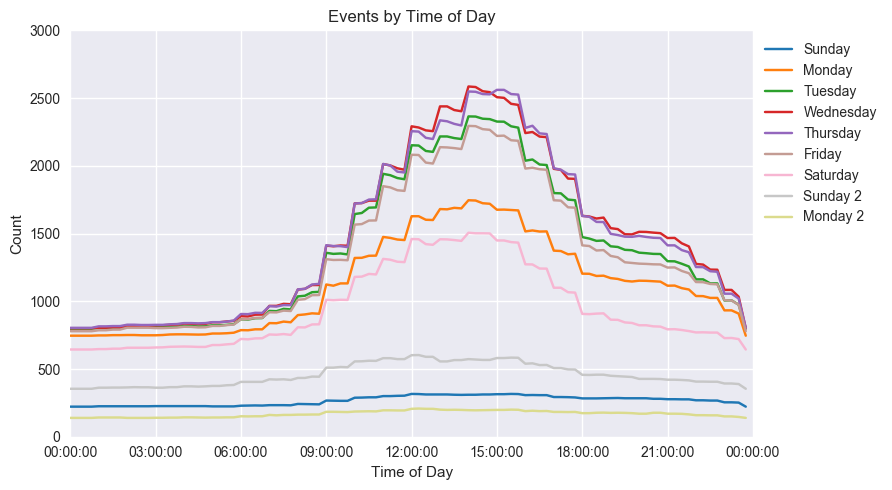

In [844]:
start = 0.0;stop = 1.0;
number_of_lines = 10;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 5), dpi=100);

axes1 = fig.add_subplot(111);

axes1.plot(df_1['time'], df_1['count'], color=colors[0], ls='-');
axes1.plot(df_2['time'], df_2['count'], color=colors[1], ls='-');
axes1.plot(df_3['time'], df_3['count'], color=colors[2], ls='-');
axes1.plot(df_4['time'], df_4['count'], color=colors[3], ls='-');
axes1.plot(df_5['time'], df_5['count'], color=colors[4], ls='-');
axes1.plot(df_6['time'], df_6['count'], color=colors[5], ls='-');
axes1.plot(df_7['time'], df_7['count'], color=colors[6], ls='-');
axes1.plot(df_8['time'], df_8['count'], color=colors[7], ls='-');
axes1.plot(df_9['time'], df_9['count'], color=colors[8], ls='-');

axes1.set_xlim(0, df_1['time'].values[-1])
axes1.set_ylim(0, 3000)
axes1.set_xticks(np.arange(0, 90000, 10800))
axes1.set_xlabel('Time of Day')
axes1.set_ylabel('Count')
axes1.set_title('Events by Time of Day')
axes1.legend(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday 2', 'Monday 2'], 
             loc='upper right', bbox_to_anchor=(1.2,1));

fig.tight_layout();

# Number of Repeated Events

About 5000 events (25% of the total) are repeated throughout the week. Most occur either twice, or five times (likely indicating Monday through Friday).

In [772]:
repeats = (df['Sunday'] != '0').astype(int) + (df['Monday'] != '0').astype(int) + (df['Tuesday'] != '0').astype(int) + (df['Wednesday'] != '0').astype(int) + (df['Thursday'] != '0').astype(int) + (df['Friday'] != '0').astype(int) +(df['Saturday'] != '0').astype(int)  + (df['Sunday2'] != '0').astype(int)  + (df['Monday2'] != '0').astype(int)

print("Total Number of Repeated Events: " + str(len([repeat for repeat in repeats if repeat > 1])))

Total Number of Repeated Events: 5126


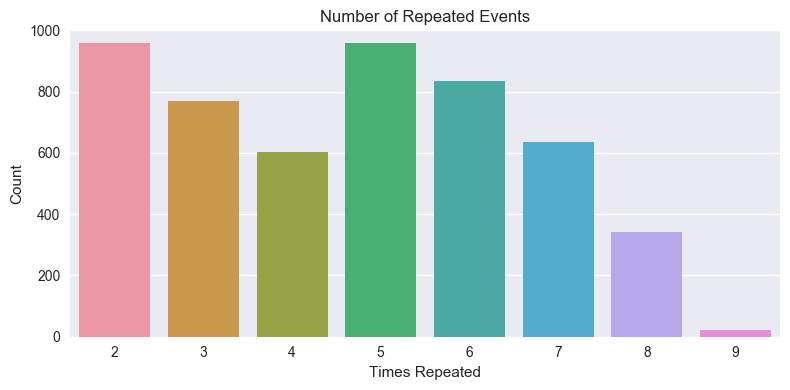

In [774]:
fig = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.countplot([repeat for repeat in repeats if repeat > 1], ax=axes1)

axes1.set_ylim(0, 1000);
axes1.set_xlabel('Times Repeated');
axes1.set_ylabel('Count');
axes1.set_title('Number of Repeated Events');

fig.tight_layout()

# Event Length Distribution

Most events are 1-2 hours long, with numerous all-day-long events. There are also a substantial number of events  with negative lengths (about 6.7%) and zero (about 0.7%) lengths! Events with negative lengths are erroneous in different ways. Some could run all day, like the Bad Idea Bar. Some could be running from, say Sunday at 10 PM to Monday at 2 AM, and therefore appear negative in the simplistic calculation.

Note that in this calculation repetitions of events are counted seperately. 

In [829]:
times_1 = pd.DataFrame(get_time_diff(df['Sunday']),    columns=['Event Length'])
times_2 = pd.DataFrame(get_time_diff(df['Monday']),    columns=['Event Length'])
times_3 = pd.DataFrame(get_time_diff(df['Tuesday']),   columns=['Event Length'])
times_4 = pd.DataFrame(get_time_diff(df['Wednesday']), columns=['Event Length'])
times_5 = pd.DataFrame(get_time_diff(df['Thursday']),  columns=['Event Length'])
times_6 = pd.DataFrame(get_time_diff(df['Friday']),    columns=['Event Length'])
times_7 = pd.DataFrame(get_time_diff(df['Saturday']),  columns=['Event Length'])
times_8 = pd.DataFrame(get_time_diff(df['Sunday2']),   columns=['Event Length'])
times_9 = pd.DataFrame(get_time_diff(df['Monday2']),   columns=['Event Length'])

times = times_1.fillna(times_2)

times = times.fillna(times_3)
times = times.fillna(times_4)
times = times.fillna(times_5)
times = times.fillna(times_6)
times = times.fillna(times_7)
times = times.fillna(times_8)
times = times.fillna(times_9)

df['Event Length'] = times

print("Total Number of Events: " + str(len(times)))
print("Total Number of Events: " + str(len(times)))
print("Percentage of Events with Negative Lengths: " + str(len([time for time in times.values if time < 0])/len(times)))
print("Percentage of Events with Zero Length: " + str(len([time for time in times.values if time == 0])/len(times)))

100%|████████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 530223.93it/s]


Total Number of Events: 20165
Percentage of Events with Negative Lengths: 0.06714604512769651
Percentage of Events with Zero Length: 0.007141086040168609


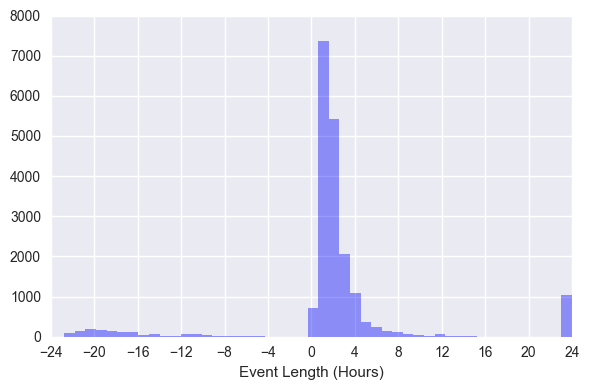

In [832]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.distplot(times, ax=axes1, kde=False, bins=48, color='blue', axlabel='Event Length (Hours)')

axes1.set_xlim(-24, 24)
axes1.set_ylim(0, 8000)
#axes1.set_yticks([])
#axes1.grid(False)
#axes1.set_facecolor('white')
#axes1.set_title('2015')
axes1.xaxis.set_major_locator(MultipleLocator(4))

fig.tight_layout()

Let's take a closer look at events with negative durations.

Event 6 and 69 seem to start at midnight, and have indefinite run times. These events should have lengths of 'NaN'

Event 69 cross from Monday at midnight into Tuesday at 4 AM. This issue could be solved by taking the absolute value of the length.

Many events with lengths of 0 effectively only have start times listed, and should also have lengths of 'NaN'

In [839]:
df[df['Event Length'] <= 0][df.columns[-9:]]

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Event Length
6,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,midnight – 11:30 p.m.,-0.25
69,midnight – 12:30 a.m.,0,0,0,0,0,0,0,-11.25
70,midnight – 4 a.m.,0,0,0,0,0,0,0,-19.75
71,midnight – midnight,0,0,0,0,0,0,0,0.00
72,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – 1 p.m.,0,0,0.00
74,midnight – midnight,0,0,0,0,0,0,0,0.00
75,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,midnight – midnight,0.00
76,midnight – midnight,0,0,0,0,0,0,0,0.00
77,midnight – 2:30 a.m.,0,midnight – 2:30 a.m.,0,0,0,0,0,-21.25
93,8:30 a.m. – 8:30 a.m.,0,0,0,0,0,0,0,0.00


# Analyzing Camps

The number of unique camps has been steadily rising, from around 300 in 2009 to almost 600 in 2017. In total there have been over 2000 unique camps!

In [4]:
print("Total Number of Unique Camps = " + str(len(df['Hosted by Camp'].unique())))

Total Number of Unique Camps = 2137


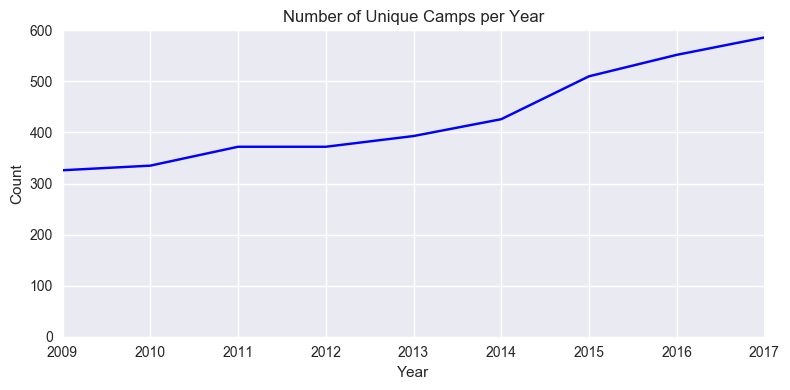

In [13]:
nmin = 150

start = 0.0;stop = 1.0;
number_of_lines = len(df['Year'].unique());
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111);

years = []
counts = []

for i, year in enumerate(df['Year'].unique()):
    years.append(year)
   
    counts.append(len(df[df['Year'] == year]['Hosted by Camp'].unique()))

axes1.plot(years, counts, color='blue', ls='-');

axes1.set_xlim(2009, 2017)
axes1.set_ylim(0, 600)
axes1.set_xlabel('Year')
axes1.set_ylabel('Count')
axes1.set_title('Number of Unique Camps per Year')

fig.tight_layout();

# Repeated Camp Names?

There do seem to be some cases of the same camps listed numerous times with slight variations of the camp name.

For example, the entries 'Ashram Galactica', 'Ashram Galactica (The Grand Hotel)', 'Ashram Galactica Resort and Conference Center', and 'Ashram Galactica, The Grand Hotel' can all be assumed to be part of a single camp called 'Ashram Galactica'

In [27]:
camps = [str(camp) for camp in df['Hosted by Camp'].unique()]

print(sorted(camps))

['!Zoom!', '"House of Dust" does Gaia', '"Ignited States"', '&', '(My First) Period Bar', '(TMWC) The Rusty Hanger, BRC Sexual Wellness Clinic', "...and then there's only LOVE", '1.21 Gigawatts', "100'th Monkey Camp", '17 Virgins', '1st Bank of BRC', '2011KING OF CARNAVAL CAMP', '3SP (Third Space Place)', '7 Deadly Gins', '7 Sins Lounge', "7 Siren's Cove", '7 Sirens Cove', '8-bit Bunny', '88', '9 Energies', '9 Energies - Know Your Superpower', 'A Camp With No Name', 'A Camp with No Name (ACWNN)', 'A Cavallo Tribal Thunder', 'A Light Hazing Camp', 'A Shack Of Sit', 'A Shack of Sit', 'A Transformation Station', 'A-TickleTrunkTastic Camp', 'ABC - Alphabet Block Camp', 'ABC Alphabet Block Camp', 'ABR: Acronym Being Reconsidered', 'ANITA COCKTAIL', 'AO (Almost Orgy)', 'AOXOMOXOA', 'APOKILIPTIKA', 'AREOLA51', 'ART OF SUCH N SUCH', 'ARTery', 'AWESOMETOWN', 'Above The Limit', 'Above The Limit (ATL)', 'AbsoFuckinLution', 'Academy of Arts and Sciences', 'Academy of Fools', 'AdramaNation', 'Adult

We can use Fuzzy Matching to camps with very similar names.

In the case of Ashram Galactica, scores of 67+ correctly match, but miss the Resort and Conference Center

In [66]:
matches = fuzzywuzzy.process.extract("Ashram Galactica", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('Ashram Galactica', 100), ('Ashram Galactica (The Grand Hotel)', 65), ('Ashram Galactica, The Grand Hotel', 65), ('AdramaNation', 57), ('AstroPups Sirian Embassy Galactic', 57), ('Camp Atlantis', 55), ('Gaylactic Invaders', 53), ('Camp Gallavant', 53), ('Galactic Labyrinth', 53), ('asana-mania', 52)]


AstroPups are missed entirely

- AstroPups
- AstroPups Sirian Embassy Galactic
- AstroPups:Warp Station Alpha
- Astropups: Burying the Bone
- Astropups: Camp Pupawannahumpya
- Astropups:Defenders of Muttropolis
- AstroPup Labs:DogVinci's Workshop

In [67]:
matches = fuzzywuzzy.process.extract("AstroPups", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('AstroPups', 100), ('Astro Cats', 63), ('Bad Asstronauts', 58), ('Circus Metropolus', 54), ('Farmopolis', 53), ('Café S?rprïsé', 53), ('Mamasaurus', 53), ('Dust Circus', 50), ('Mobtropolis', 50), ('Astropups: Burying the Bone', 50)]


As well as BMIR, which occurs as:

- BMIR
- BMIR - Burning Man Information Radio 94.5 FM
- BMIR 94.5 FM
- BMIR, Burning Man Information Radio 94.5 FM
- BMIR-FM, Burning Man Information Radio 94.5

In [68]:
matches = fuzzywuzzy.process.extract("BMIR", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('BMIR', 100), ('Shibumi', 55), ('Wabi', 50), ('BMIR 94.5 FM', 50), ('Brûlée', 50), ('Backfire', 50), ('Bierdhaus', 46), ('MindShark', 46), ('BRC MoIST', 46), ('Miso Horny', 43)]


Barbie Death Camp doesn't too too bad. A score of 74 gets 4, although we still miss the Village.

In [69]:
matches = fuzzywuzzy.process.extract("Barbie Death Camp", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('BARBIE DEATH CAMP', 100), ('Barbie Death Camp', 100), ('Barbie Death Village', 76), ('Barbarian Camp', 71), ('Barbie Death Camp & Wine Bistro', 71), ('Barbie Death Camp & Wine Bistro ', 71), ('Barbie Day Spa', 71), ('Advice Booth Camp', 65), ('Rat Camp', 64), ('Back To Camp', 62)]


And just to see what kind of false positives we could get with common strings:

In [70]:
matches = fuzzywuzzy.process.extract("BRC", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('BRC3PO', 67), ('BRC HOA', 60), ('Brûlée', 57), ('BMIR', 57), ('FTB+C', 50), ('BRC MoIST', 50), ('T.B.C.', 50), ('BurnSecret', 46), ('Bounce!', 44), ('Brulee', 44)]


In [71]:
matches = fuzzywuzzy.process.extract("Playa", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('Playagon', 77), ('Playa 54', 77), ('Playatel', 77), ('PLAYA 54', 77), ('¡Playasos!', 77), ('PlayaTune', 71), ('Playa Info', 67), ('PlayaNauts', 67), ('PlayaSkool', 67), ('Playasophy', 67)]


In [72]:
matches = fuzzywuzzy.process.extract("Spank", camps, limit=10, scorer=fuzzywuzzy.fuzz.QRatio)

print(matches)

[('Spank Bank', 67), ('Otis Spankmore', 53), ('nan', 50), ('Pandora', 50), ('SNO*PAC', 50), ('Sexagon', 50), ('Speakcheasy', 50), ('Jipangu', 50), ('Sextant', 50), ("Spanky's Village", 48)]


Unfortunately it doesn't look like any simple fuzzy-matching can solve this problem. We'll need to dig deeper into the fuzzy match scoring to see if we can figure this one out.

# Who are the most active camps?

Across the years, the Sacred Spaces Village, by far, has been most active in posting their events into the schedule. Although given the fuzzy matching issue, it is possible that other, less consistently named camps, may in reality be further ahead in the rankings.

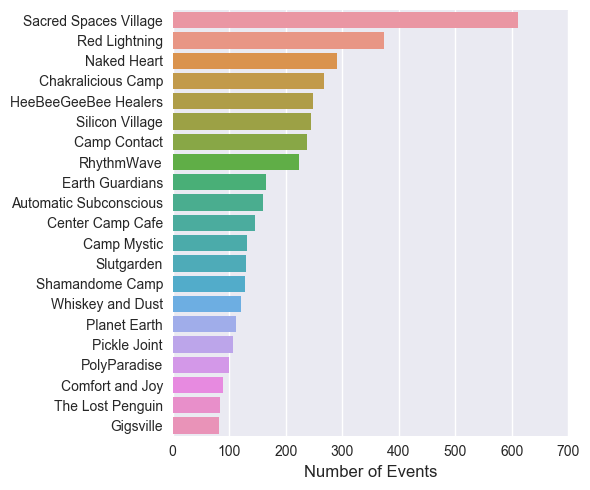

In [36]:
camp_count = df['Hosted by Camp'].value_counts().reset_index();

camp_count = camp_count[camp_count['index'] != '-'];

camp_count_filtered = camp_count[camp_count['Hosted by Camp'] > 80];

fig = plt.figure(figsize=(6, 5), dpi=100);

axes1 = fig.add_subplot(111); 

sns.barplot(x='Hosted by Camp', y='index', data=camp_count_filtered, ax=axes1);

axes1.set_xlim(0, 700);
axes1.set_ylabel('');
axes1.set_xlabel('Number of Events', size=12);
axes1.tick_params(axis='both', which='major', labelsize=10);

fig.tight_layout();

Looking at the event count per year of the most active camps, we can see that the most active camp, Sacred Spaces, had participation sharply drop to zero after 2013, indicating Camp Death. Naked Heart, on the other hand, has been steadily rising in 2012 and should be a big presence this coming year.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


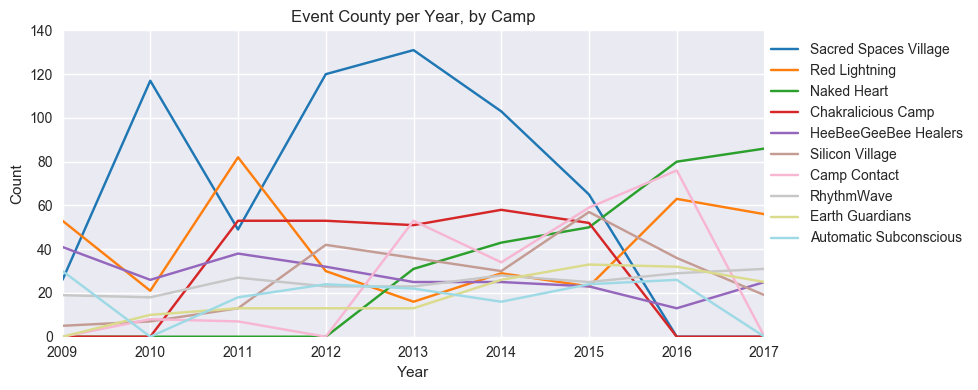

In [873]:
nmin = 150

start = 0.0;stop = 1.0;
number_of_lines = len(camp_count[camp_count['Hosted by Camp'] > nmin]['index'].values);
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.tab20(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100);

axes1 = fig.add_subplot(111);

for i, camp_name in enumerate(camp_count[camp_count['Hosted by Camp'] > nmin]['index'].values):
    years = []
    count = []

    for year in df['Year'].unique():
        years.append(year)

        count.append(len(df[df['Year'] == year][df['Hosted by Camp'] == camp_name]))
    
    axes1.plot(years, count, color=colors[i], ls='-');


axes1.set_xlim(2009, 2017)
axes1.set_ylim(0, 140)
axes1.set_xlabel('Year')
axes1.set_ylabel('Count')
axes1.set_title('Event County per Year, by Camp')

axes1.legend(camp_count[camp_count['Hosted by Camp'] > nmin]['index'].values, loc='upper right', bbox_to_anchor=(1.3, 1));

fig.tight_layout();

# Let's take a look at the event descriptions

The mean-average length of an event description is approximately 50 words with 300 characters. 

In [618]:
# Convert Dataframe Column to a joined array of strings
text = ' '.join(list(df.Description.values.astype(str))).lower().replace('\n', '').replace('\r', '');

# How many words in total are there?
print('Character Count = ' + str(len(text)));
print('Mean Average Character Count = ' + str(len(text)/len(df.Description.values)));

print('Total Word Count = ' + str(len(text.split())));
print('Mean Average Word Count = ' + str(len(text.split())/len(df.Description.values)));

Character Count = 5999673
Mean Average Character Count = 297.5290354574758
Total Word Count = 1015532
Mean Average Word Count = 50.36112075378131


Looking at a character distribution plot however, we see that the distribution is peaked at just over 100 characters. The mean average is skewed right by outliers.

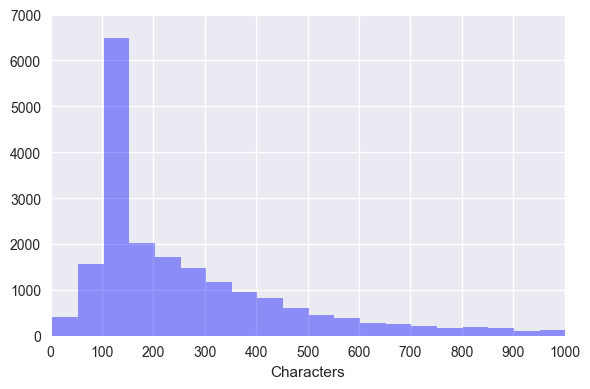

In [146]:
fig = plt.figure(figsize=(6, 4), dpi=100);

axes1 = fig.add_subplot(111);

sns.distplot([len(event) for event in list(df.Description.values.astype(str))], ax=axes1, 
             kde=False, bins=40, color='blue', axlabel='Characters')

axes1.set_xlim(0, 1000)
axes1.set_ylim(0, 7000)
#axes1.set_yticks([])
#axes1.grid(False)
#axes1.set_facecolor('white')
#axes1.set_title('2015')
axes1.xaxis.set_major_locator(MultipleLocator(100))

fig.tight_layout()

In [610]:
count_vect_desc  = CountVectorizer(stop_words='english', min_df=100, ngram_range=(1, 3), analyzer='word')

X = count_vect_desc.fit_transform(events['Description'].values);

In [646]:
tokenizer = RegexpTokenizer(r'\w+');

event_fdists = []

for event_type in tqdm(event_types):
    event_text = ' '.join(list(df[df['Type'] == event_type]['Description'].values.astype(str))).lower().replace('\n', '').replace('\r', '')
    
    event_tokens = tokenizer.tokenize(event_text);

    event_Text = nltk.Text(event_tokens)
    
    event_filtered_words = [word for word in event_Text if word not in stopwords.words('english')];

    event_filtered_words = [word for word in event_filtered_words if len(word) > 3];

    event_fdist_filtered = nltk.FreqDist(event_filtered_words);
    
    event_fdists.append(event_fdist_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [04:42<00:00, 23.54s/it]


In [650]:
most_common_df = pd.DataFrame()

for event_type, event_fdist in zip(event_types, event_fdists):
    print(event_fdist)
    most_common_df[event_type] = [word[0] for word in event_fdist.most_common(40)]

<FreqDist with 8637 samples and 34478 outcomes>
<FreqDist with 3455 samples and 10590 outcomes>
<FreqDist with 17360 samples and 128875 outcomes>
<FreqDist with 5845 samples and 23542 outcomes>
<FreqDist with 6135 samples and 36214 outcomes>
<FreqDist with 7221 samples and 31135 outcomes>
<FreqDist with 5039 samples and 18780 outcomes>
<FreqDist with 17499 samples and 168162 outcomes>
<FreqDist with 9777 samples and 44849 outcomes>
<FreqDist with 4775 samples and 18989 outcomes>
<FreqDist with 1894 samples and 4312 outcomes>
<FreqDist with 2991 samples and 10028 outcomes>


Surprise surpise. The most common word in "Fire" events is... fire! 

"Come" is common all-around, as well as "playa" for that matter, and should be considered a stopword, along with "join".

Then "game" becomes the most common word for "Game" events. 

Likewise kid-friendly events have "kids" as the 4th most common word. And "Gathering/Party" events have "dance, party, music" as common words.

In [651]:
most_common_df

,Other,Kid-friendly,Gathering/Party,Game,Adult-oriented,Ritual/Ceremony,Care/Support,Class/Workshop,Performance,Food,Fire,Parade
0,come,come,come,come,come,come,come,come,come,come,fire,playa
1,playa,camp,playa,game,play,playa,playa,learn,playa,playa,come,join
2,camp,playa,party,playa,bring,join,camp,bring,music,bring,spin,camp
3,bring,kids,dance,play,playa,bring,healing,body,show,coffee,bring,parade
4,join,bring,join,camp,experience,ceremony,help,playa,live,camp,fuel,meet
5,like,black,bring,bring,safe,love,body,yoga,join,enjoy,burn,march
6,music,rock,music,join,open,ritual,need,dance,bring,join,join,bring
7,time,make,camp,games,partner,temple,bring,experience,stage,pickle,night,come
8,dance,city,night,prizes,learn,life,massage,join,camp,cold,playa,around
9,take,take,enjoy,time,space,dance,open,workshop,rock,food,burning,black


Let's take a look at common text collocations with the nltk package.

In [619]:
# Convert strings to nltk "token" objects
tokenizer = RegexpTokenizer(r'\w+');

tokens = tokenizer.tokenize(text);

# Convert tokens into an nltk "Text" object
Text = nltk.Text(tokens);

# Filter out stop words
filtered_words = [word for word in Text if word not in stopwords.words('english')];

# Filter out short words
filtered_words = [word for word in filtered_words if len(word) > 3];

fdist_filtered = nltk.FreqDist(filtered_words);

In [153]:
Text.collocations()

burning man; black rock; rock city; happy hour; center camp; come
join; hip hop; art car; feel free; default world; http www; live
music; dance party; every day; dance floor; last year; san francisco;
bloody mary; ice cold; low club


For easy visualization, create a word cloud of the most common words in event descriptions.

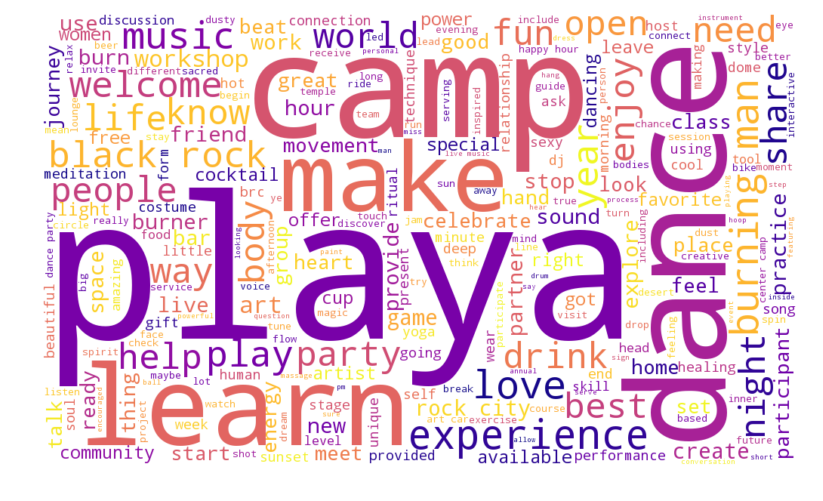

In [155]:
limit = 250
bgcolor = '#FFFFFF'
specific_stopwords = ['come', 'bring', 'join', 'let', 'daily', 'nthe', 'let', 'event', 'want', 'time', 'dj', 'day']
english_stopwords = set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(specific_stopwords)

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'plasma'
).generate(text)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

# Sentiment Analysis

Let's run a quick sentiment analysis with NLTK's VADER algorithm. 

Looks like the overall sentiment score is close to neutral and slightly positive.

If we look at the distribution of scores by event, we see that the descriptions are definitely not negative, only a little positive, and with a large degree of neutrality. The compound score is positive-leaning, but with a large peak near zero.

...although perhaps we shouldn't put too much stock on this particular sentiment analysis. Burners enjoy wordplay, snark, and have their own slang, which may not be adequatly captured.

In [242]:
sia = SIA();

polarity_scores = [sia.polarity_scores(str(event)) for event in df.Description.values];

overall_polarity = sia.polarity_scores(' '.join(df.Description.values))

print('Overall Polarity Scores: ' + str(overall_polarity));

Overall Polarity Scores: {'neg': 0.049, 'neu': 0.748, 'pos': 0.203, 'compound': 1.0}


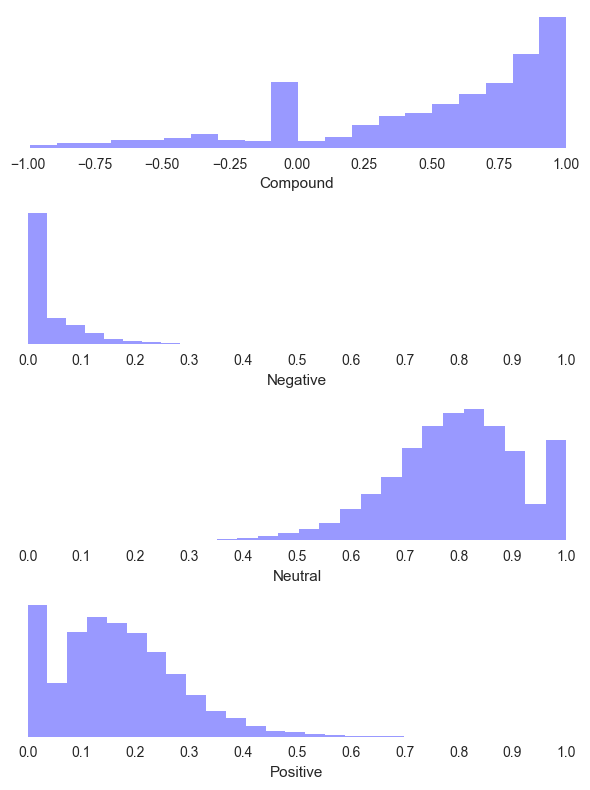

In [382]:
fig = plt.figure(figsize=(6, 8), dpi=100);

axes1 = fig.add_subplot(411); axes2 = fig.add_subplot(412);   axes3 = fig.add_subplot(413);   axes4 = fig.add_subplot(414); 

sns.distplot([event['compound'] for event in polarity_scores], ax=axes1, kde=False, bins=20, color='blue', axlabel='Compound')
sns.distplot([event['neg']      for event in polarity_scores], ax=axes2, kde=False, bins=20, color='blue', axlabel='Negative')
sns.distplot([event['neu']      for event in polarity_scores], ax=axes3, kde=False, bins=20, color='blue', axlabel='Neutral')
sns.distplot([event['pos']      for event in polarity_scores], ax=axes4, kde=False, bins=20, color='blue', axlabel='Positive')

axes1.set_xlim(-1, 1);
axes2.set_xlim(0, 1);
axes3.set_xlim(0, 1);
axes4.set_xlim(0, 1);

axes1.set_yticks([]);axes2.set_yticks([]);axes3.set_yticks([]);axes4.set_yticks([]);

axes1.grid(False);axes2.grid(False);axes3.grid(False);axes4.grid(False);

axes2.xaxis.set_major_locator(MultipleLocator(0.1))
axes3.xaxis.set_major_locator(MultipleLocator(0.1))
axes4.xaxis.set_major_locator(MultipleLocator(0.1))

axes1.set_facecolor('white');axes2.set_facecolor('white');axes3.set_facecolor('white');axes4.set_facecolor('white');

fig.tight_layout()

# How are event locations distributed?

The Area Known as Burning Man is referred to as Black Rock City by the natives. It has a circular structure consisting of radials with clock-like names, and arcs with alphabetical names.

![](images/Map.jpg)

Let's look at what event locations look like. Some look like Camp Names. Some are mappable locations like '5:45 & G'. Some are erroneous entries of emails and websites. Others seem like total nonsense.

In [77]:
[location for location in df[df['Year'] == 2017]['Location'].values if not pd.isnull(location)]

['citizenmeow',
 'Camp Beaverton',
 '8:15 & D',
 'sick.jon@gmail.com',
 'Wandering all over BRC',
 'wolfcub',
 'rangerlightchaser@gmail.com',
 'Court Yard at Comfort & Joy Village',
 'Court Yard at Comfort & Joy Village',
 'citizenmeow',
 'Court Yard at Comfort & Joy Village',
 'Pink Gym at Comfort & Joy Village',
 'Pepperland',
 '6:45 Dance',
 'Anahasana Village',
 'Center Camp Cafe Performance Stage',
 'in Tiara at Comfort & Joy Village',
 'Pepperland',
 'Camp Settle This Like Men',
 'Camp Settle This Like Men',
 'dillowsky',
 'On 4:30 and D',
 "The Camp for Sensual Pleasures in Spanky's Village and Wine Bar",
 "The Camp for Sensual Pleasures in Spanky's Village and Wine Bar",
 'lifeinflow',
 'Center Camp',
 'At Valhalla on the Playa camp',
 'minstrelcramp',
 'Plaza at 4:30 or 7:30',
 'The Black Rock Beacon is located at Iron Rose this year.',
 'Power Room at Comfort & Joy Village',
 'beth.pferd@gmail.com',
 'SNAP Camp + Cafe',
 'VoiceOfReason',
 'Camp Settle This Like Men',
 'Maripo